# 1 Introduction

### 1-1 Quantum Simulation
One of the leading uses for quantum computers will be to simulate quantum systems such as molecules or engineered materials. Actually executing a quantum simulation on a current quantum computer, however, can be difficult and error prone. Your objective for this lab is to complete the exercises and then improve on them to get the highest state tomography score (more details in Section 2).

The quantum system you will simulate is a quantum spin-1/2 model, where each qubit represents a quantum [spin-1/2](https://en.wikipedia.org/wiki/Spin-1/2) particle in a 1D chain. Quantum spin models have some amazing properties and uses. Computationally speaking, [certain optimization problems can be mapped](https://arxiv.org/pdf/1712.05771.pdf) to spin models and hence minimized on a quantum computer. Physically speaking, spin models show a variety of quantum behavior such as large entangled states, quantum phases of matter, quantum many-body affects, and many other open questions in physics research.

There are many different spin models, but we will focus on the [$XXX$ Heisenberg spin model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model#XXX_model). Though it is not as well known as the [transverse-field Ising model](https://en.wikipedia.org/wiki/Transverse-field_Ising_model), the $XXX$ Heisenberg model is of practical and theoretical interest. It can also be difficult to simulate, which is where you come in.

The notebook is organized as follows:
1) Section 1 (labeled 1-X) provides you with brief introductions to the $XXX$ Heisenberg model, time evolving a Hamiltonian, and decomposing a time evolution operator into gates for a quantum computer to execute.
2) Section 2 (labeled 2-X) outlines the specific requirements and boundaries associated with completing the exercises and competing for the best score. Completing the exercises will give you an example solution. Once you've completed the exercises, feel free to modify your answers to get the best score.

In [156]:
!pip install qiskit_ignis
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), Pauli operators (X, Y, Z), and the identity operator (I)
from qiskit.opflow import Zero, One, X, Y, Z, I

import numpy as np
from qiskit.opflow import I, X, Y, Z, H, CX, Zero, ListOp, PauliExpectation, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.compiler import transpile
import qc_grader

from qiskit.quantum_info import Pauli, PauliList
from qiskit.opflow.primitive_ops.pauli_op import PauliOp
from qiskit.circuit import QuantumCircuit, Parameter



### 1-2 The $XXX$ Heisenberg Spin Model

To simulate a quantum system, we first need to define how the quantum particles that make up the system interact with each other. In quantum physics, this is done by defining a [Hamiltonian operator](https://en.wikipedia.org/wiki/Hamiltonian_(quantum_mechanics)). For this lab, you will work with the $XXX$ Heisenberg Hamiltonian $H_{\text{Heis}}$ as defined below

$$
H_{\text{Heis}} = \sum_{\langle ij \rangle}^{N} J \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right).
$$

$N$ is the number of spin-1/2 particles in model. The operators $\sigma_x$, $\sigma_y$, and $\sigma_z$ are [Pauli operators](https://en.wikipedia.org/wiki/Pauli_matrices) where the $i$ and $j$ superscripts label which qubit they act on. For example, $\sigma_x^{(1)}$ would be the $\sigma_x$ operator acting on only qubit 1 (which is the 2nd qubit since indexing starts at 0). This version of the general Heisenberg spin model is called $XXX$ because the same $J$ value multiplies each pair of Pauli operators. The sum notation $\langle ij \rangle$ means the sum is over nearest neighbors (only qubits next to each other interact), and $J$ is the interaction strength, which we will set $J=1$.

You will work with the explicit case of $N=3$ with the 3 spins arranged in a line. Written out fully, the Hamiltonian is
$$
H_{\text{Heis3}} = \sigma_x^{(0)}\sigma_x^{(1)} + \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(0)}\sigma_z^{(1)} + \sigma_z^{(1)}\sigma_z^{(2)}.
$$
Now that we have a Hamiltonian ($H_{\text{Heis3}}$), we can use it to determine how the quantum system of 3 spin-1/2 particles changes in time.

### 1-3 Using OpFlow
Qiskit offers [functionality for mathematically working with quantum states and operators](https://qiskit.org/documentation/apidoc/opflow.html) called ```opflow``` with tutorials found [here](https://qiskit.org/documentation/tutorials/operators/index.html). Opflow is especially convenient when dealing with large numbers of qubits as tensor products can become unwieldy when using numpy both in size and syntax. Your first exercise is to write the above Hamiltonian $H_{\text{Heis3}}$ in opflow.

In [157]:
# Returns the XXX Heisenberg model for 3 spin-1/2 particles in a line
def ex1_compute_H_heis3():
    # FILL YOUR CODE IN HERE
    pauli_list = []
    m = ['X', 'Y', 'Z', 'I']
    for p in m:
        t = Pauli(p)
        pauli_list.append(PauliOp(t))
    x = pauli_list[0]
    y = pauli_list[1]
    z = pauli_list[2]
    i = pauli_list[3]
    
    H = (i^x^x) + (x^x^i) + (i^y^y) + (y^y^i) + (i^z^z) + (z^z^i)
    
    # Return Hamiltonian
    return H

In [158]:
from qc_grader.challenges.qgss_2022 import grade_lab4_ex1

# The grading function is expecting a PauliSumOp operator
grade_lab4_ex1(ex1_compute_H_heis3())

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### 1-4 Time Evolution

Knowing the Hamiltonian, we can determine how quantum states of that system evolve in time by solving the [Schrödinger equation](https://en.wikipedia.org/wiki/Schrödinger_equation)
$$
i\hbar \dfrac{d}{dt}|\psi(t)\rangle = H |\psi(t)\rangle .
$$

For simplicity, let's set $\hbar = 1$. We know that the Hamiltonian $H_{\text{heis3}}$ does not change in time, so the solution to the Schrödinger equation is an exponential of the Hamiltonian operator
$$
\begin{align}
U_{\text{Heis3}}(t) &= e^{-it H_\text{Heis3}} = \exp\left(-it H_\text{Heis3}\right) \\
U_{\text{Heis3}}(t) &= \exp\left[-it \sum_{\langle ij \rangle}^{N=3} \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right) \right] \\
U_{\text{Heis3}}(t) &= \exp\left[-it \left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(0)}\sigma_z^{(1)} + \sigma_z^{(1)}\sigma_z^{(2)}\right) \right]
\end{align}
$$.

Now that we have the time evolution operator $U_{\text{Heis3}}(t)$, we can simulate changes in a state of the system ($|\psi(t)\rangle$) over time $|\psi(t)\rangle = U_{\text{Heis3}}(t)|\psi(t=0)\rangle$.

Using opflow methods again, your second exercise is to compute the unitary time evolution under the Hamiltonian you constructed from exercise 1 for a given time t.

In [159]:
# Returns the time evolution operator U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def ex2_compute_U_heis3(t):
    # FILL YOUR CODE IN HERE
    H = ex1_compute_H_heis3()
    U = (t*H).exp_i()
    return U

In [160]:
from qc_grader.challenges.qgss_2022 import grade_lab4_ex2

# The grading function is expecting a funtion that returns PauliSumOp operator
grade_lab4_ex2(ex2_compute_U_heis3)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### 1-5 Classical Simulation of $H_{\text{Heis3}}$

Now that we have the operator $U_{\text{Heis3}}(t)$ which describes how any state of the quantum system changes in time, we can simulate the $XXX$ Heisenberg spin model! Just for fun, let's simulate the system using a classical computer first.

(Fun fact: Notice the size of $U_{\text{Heis3}}(t)$ in matrix form. It's represented by an $8$x$8$ matrix. This is because there are $2^3=8$ states in the $N=3$ system. If the simulation were of $50$ particles ($N=50$), $U_{\text{Heis}}(t)$ would be approximately $10^{15}$x$10^{15}$! Well beyond the capacity of today's computers.)

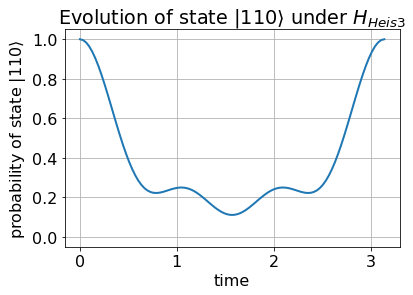

In [161]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # ex2_compute_U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|ex2_compute_U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110 = [np.abs((~initial_state @ ex2_compute_U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110, linewidth=2)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.ylim([-0.05,1.05])
plt.grid()
plt.show()

### 1-6 Decomposition of $U_{\text{Heis3}}(t)$ Into Quantum Gates

To execute $U_{\text{Heis3}}(t)$ on a [circuit model](https://qiskit.org/documentation/apidoc/circuit.html) quantum computer, we must decompose $U_{\text{Heis3}}(t)$ into a product of single and two-qubit gates that are native to that quantum computer. There are a [variety of techniques](https://en.wikipedia.org/wiki/Hamiltonian_simulation) to do this. For this lab, you will only use [Trotterization](https://en.wikipedia.org/wiki/Hamiltonian_simulation#Product_Formulas) (which is sometimes referred to as the Suzuki-Trotterization decomposition, Trotter formulas, product formulas, and other names).

Below, we show an example Trotterization as outlined in \[1-2\].

Since the [Pauli operators do not commute](https://en.wikipedia.org/wiki/Pauli_matrices#Commutation_relations) with each other, the exponential $U_{\text{Heis3}}(t)$ cannot be split into a product of simpler exponentials. However, we can approximate $U_{\text{Heis3}}(t)$ as a product of simpler exponentials through Trotterization. Consider a subsystem of 2 spin-1/2 particles within the larger 3 spin system. The Hamiltonian on spins $i$ and $j$ ($i,j \in \{0,1,2\}$) would be $H^{(i,j)}_{\text{Heis2}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}$. Rewriting $U_{\text{Heis3}}(t)$ in terms of the two possible subsystems within the total $N=3$ system you will simulate,

$$
U_{\text{Heis3}}(t) = \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right].
$$

$H^{(0,1)}_{\text{Heis2}}$ and $H^{(1,2)}_{\text{Heis2}}$ do not commute, so $U_{\text{Heis3}}(t) \neq \exp\left(-i t H^{(0,1)}_{\text{Heis2}}\right) \exp\left(-i t H^{(1,2)}_{\text{Heis2}} \right)$. But, this product decomposition can be approximated with Trotterization which says $U_{\text{Heis3}}(t)$ is approximately a short evolution of $H^{(0,1)}_{\text{Heis2}}$ (time = $t/n$) and followed by a short evolution of $H^{(1,2)}_{\text{Heis2}}$ (time = $t/n$) repeated $n$ times

$$
\begin{align}
U_{\text{Heis3}}(t) &= \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right] \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}} \right)\right]^n.
\end{align}
$$

$n$ is the number of Trotter steps, and as $n$ increases, the approximation becomes more accurate. (Note that how a unitary is split up into subsystems for Trotterization is not necessarily unique.) The decomposition goes further. Within each 2 spin subsystems, the Pauli operator pairs ($\sigma_x^{(i)}\sigma_x^{(j)}$, $\sigma_y^{(i)}\sigma_y^{(j)}$, and $\sigma_z^{(i)}\sigma_z^{(j)}$) commute. This means we can decompose the exponential of a subsystem Hamiltonian ($H^{(i,j)}_{\text{Heis2}}$) into a product of even simpler exponentials getting us closer to a gate implementation of $U_{\text{Heis3}}(t)$

$$
\begin{align}
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}} \right)\right]^n \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_z^{(0)}\sigma_z^{(1)}\right)\right) \exp\left(\dfrac{-it}{n}\left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right)\right)\right]^{n} \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(0)}\sigma_z^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_x^{(1)}\sigma_x^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(1)}\sigma_y^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(1)}\sigma_z^{(2)}\right)\right]^{n}
\end{align}
$$

For simplicity, and to use more common notation, let's rename the products with $XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$, $YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$, and $ZZ(2t) = \exp\left(-it \sigma_z\sigma_z\right)$ and rewrite the Trotterized $U_{\text{Heis3}}(t)$
$$
U_{\text{Heis3}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)} ZZ\left(\frac{2t}{n}\right)^{(0,1)} XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)} ZZ\left(\frac{2t}{n}\right)^{(1,2)} \right]^{n}
$$
And that's it! We have now approximately decomposed $U_{\text{Heis3}}(t)$ into two-qubit gates $XX(t)$, $YY(t)$, and $ZZ(t)$. Note that these gates are not native to superconducting qubits, but in Section 2, they will be further decomposed into native single and two-qubit gates.


\[1\] Y. Salathe, et al., *Digital Quantum Simulation of Spin Models with Circuit Quantum Electrodynamics*, [Phys. Rev. X **5**, 021027 (2015)](https://link.aps.org/doi/10.1103/PhysRevX.5.021027)

\[2\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) \[[free arXiv version](https://arxiv.org/abs/1907.03505)\]


# 2 Contest: Optimal Time Evolution
### 2-1 Contest Details
For this lab, we will have a fun, no pressure contest to get the best quantum simulation. Below is an outline of contest guidelines.

You are to time evolve the state $|110\rangle$ to time $t=\pi$ under the $XXX$ Heisenberg model Hamiltonian $H_{\text{heis3}}$ as defined in Section 1. This will be done on the ibmq_manila quantum computer and noisy simulator. The qubits in the state $|110\rangle$ could correspond to any three qubits of ibmq_manila. The evolution must be done using Trotterization with at least 4 steps ($n\geq 4$). You will compete based on the fidelity of the evolved state at time $t=\pi$ using [state tomography](https://qiskit.org/documentation/tutorials/noise/8_tomography.html). State tomography is a way of determining the exact quantum state--even phase information--at the end of a quantum circuit by running the circuit multiple times and measuring in different bases. The closer your final quantum state to the expected state, the higher the fidelity. As you work on your solution, other important elements to consider are clarity of your code and how many different techniques you can learn and bring together. This is a great time to practice a variety of skills. Ibmq_manila's remaining two qubits will not be evaluated by the state tomography calculation, so you may use them as you wish. You do not need to follow the same decomposition given in the example above, but your solution must be a Trotterization of $U_{\text{heis3}}(t)$ with at least 4 steps ($n\geq 4$). You will find it useful to implement ideas and techniques you learned during this summer school that reduce errors and improve qubit coherence.

### 2-2 Import Qiskit

Feel free to import packages as needed. However, please keep to free packages and those obtained through ```pip install``` or ```conda install```.

In [162]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

### 2-3 Quantum Devices
Connect to IBM provider and connect to a real or simulated backend. Final submissions must be run on a real backend, but simulated devices are faster for debugging and testing.

In [163]:
# load IBMQ Account data

# IBMQ.save_account(TOKEN)  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-07-27 20:00:27,173: Credentials are already in use. The existing account in the session will be replaced.


In [164]:
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q')
manila = provider.get_backend('ibmq_manila')
# properties = manila.properties()

# Simulated backend based on ibmq_manila's device noise profile
sim_noisy_manila = QasmSimulator.from_backend(provider.get_backend('ibmq_manila'))

# Noiseless simulated backend
sim = QasmSimulator()

### 2-4 Decomposition of $U_{\text{Heis3}}(t)$ into Quantum Gates (Example)

The following circuit code is written based on the example given in Section 1. This is where you write your solution.

YOUR TROTTERIZATION GOES HERE -- START (beginning of example)

In [165]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

In [166]:
# Build a subcircuit for XX(t) two-qubit gate
def compute_XX_gate(t):
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr, name='XX')

    XX_qc.ry(np.pi/2,[0,1])
    XX_qc.cnot(0,1)
    XX_qc.rz(2 * t, 1)
    XX_qc.cnot(0,1)
    XX_qc.ry(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    XX = XX_qc.to_instruction()
    return XX


In [167]:
# Build a subcircuit for YY(t) two-qubit gate
def ex3_compute_YY_gate(t):
    # FILL YOUR CODE IN HERE
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr, name='YY')

    YY_qc.rx(np.pi/2,[0,1])
    YY_qc.cnot(0,1)
    YY_qc.rz(2 * t, 1)
    YY_qc.cnot(0,1)
    YY_qc.rx(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    YY = YY_qc.to_instruction()
    
    return YY


In [168]:
from qc_grader.challenges.qgss_2022 import grade_lab4_ex3

# The grading function is expecting an Instruction
grade_lab4_ex3(ex3_compute_YY_gate(t))

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [169]:
# Build a subcircuit for ZZ(t) two-qubit gate
def ex4_compute_ZZ_gate(t):
    # FILL YOUR CODE IN HERE
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

    ZZ_qc.rx(np.pi,[0,1])
    ZZ_qc.cnot(0,1)
    ZZ_qc.rz(2 * t, 1)
    ZZ_qc.cnot(0,1)
    ZZ_qc.rx(-np.pi,[0,1])
    
    # Convert custom quantum circuit into a gate
    ZZ = ZZ_qc.to_instruction()
    
    return ZZ

In [170]:
from qc_grader.challenges.qgss_2022 import grade_lab4_ex4

# The grading function is expecting an Instruction
grade_lab4_ex4(ex4_compute_ZZ_gate(t))

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Combine subcircuits into single gate representing one ($n=1$) trotter step.

In [171]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

# Define two-qubit interactions Parameterized by t
XX = compute_XX_gate(t)
YY = ex3_compute_YY_gate(t)
ZZ = ex4_compute_ZZ_gate(t)

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

YOUR TROTTERIZATION GOES HERE -- FINISH (end of example)

### 2-5 Trotterized Time Evolution

Time evolve the state $|110\rangle$ from $\theta=0$ to $\theta=\pi$ under $H_{\text{heis3}}$. Although manila has five qubits, only three of the qubits will be used for the state $|110\rangle$. From left to right, the qubits in the state $|110\rangle$ could correspond to any of the five qubits. State tomography will evaluate how well the quantum simulation matches to the expected state at $\theta= \pi$. (Note the two remaining qubits will not part of the state tomography calculation.)

You choose how many trotter steps (```trotter_steps```) to take in the simulation, but it must be at least 4. The code below is written to be generic enough for you may add to it if necessary for your solution.

In [172]:
# Setup experiment parameters

# The final time of the state evolution
target_time = np.pi  # DO NOT MODIFY

# Number of trotter steps
trotter_steps = 4  ### CAN BE >= 4

# Select which qubits to use for the simulation
q_regs = [0,1,2]

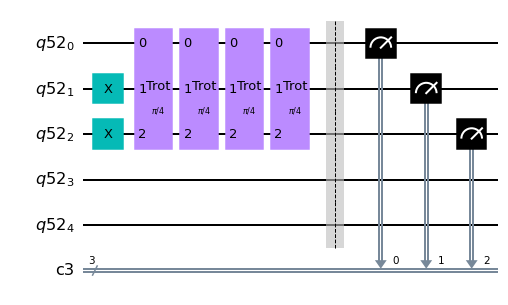

In [173]:
# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(5)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on manila qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([q_regs[2], q_regs[1]])  # For example this could be (q_regs=[2, 1, 0] which corresponds to => |110>)

# Simulate time evolution under H_heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(Trot_gate, q_regs)

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({t: target_time/trotter_steps})

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, q_regs)

# Display circuit for confirmation
# st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
st_qcs[-1].draw()  # only view trotter gates

### 2-6 Execute
For your final submission, you will need to execute your solution on a real backend with four repetitions. For faster debugging, considering using a simulated backend and/or 1 repetition.

In [174]:
shots = 8192
reps = 4

# Pick the simulated or real backend for manila
backend = sim  # Noiseless simulator
# backend = sim_noisy_manila  # Simulator that mimics ibmq_manila
# backend = manila  # The real manila backend

jobs = []
for _ in range(reps):
    # Execute
    job = execute(st_qcs, backend, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID dcdf72f4-3c0b-4317-858d-92125fc79270
Job ID c4f214b2-faaa-4006-bc43-44f185981069
Job ID 833f3f38-50e0-437b-af9f-60449767f515
Job ID b71c6661-14c9-415b-9cc2-1173aa7354a1


We can monitor the status of the jobs using Qiskit's job monitoring tools.

In [175]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


### 2-7 Results Analysis
Extract the results for the completed jobs and compute the state tomography fidelity for each repetition. You may choose to include other post-processing analyses here as well.

In [176]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute tomography fidelities for each repetition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
# Share tomography fidelity of discord to compete and collaborate with other students
print('state tomography fidelity on ' + str(backend) + ' = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
# Share what lectures and techniques were useful in optimizing your results
print('Inspiration: Measurement error mitigation, Olivia Lanes\'s 2nd lecture')

state tomography fidelity on qasm_simulator = 0.0004 ± 0.0007
Inspiration: Measurement error mitigation, Olivia Lanes's 2nd lecture


In [177]:
import qiskit.tools.jupyter
%qiskit_version_table